In [20]:
!pip install yfinance sklearn

In [21]:
#load data
import yfinance as yf

df = yf.Ticker("2609.TW").history(period="10y")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-05-27,21.765425,21.932850,21.597999,21.681711,2623795,0.0,0.0
2013-05-28,21.681712,21.765426,21.430572,21.514286,2042421,0.0,0.0
2013-05-29,21.514286,21.681712,21.514286,21.598000,1751734,0.0,0.0
2013-05-30,21.597999,21.597999,21.095719,21.179432,4187606,0.0,0.0
2013-05-31,21.430571,21.430571,21.263146,21.430571,2160884,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-19,61.400002,61.599998,61.000000,61.299999,8611586,0.0,0.0
2023-05-22,61.400002,62.500000,61.099998,62.099998,15044999,0.0,0.0
2023-05-23,62.200001,62.200001,61.599998,61.700001,9943548,0.0,0.0


In [22]:
#取開盤價
df = df.filter(["Close"])
df = df.rename(columns={"Close":"GT"})
df

,GT
Date,
2013-05-27,21.681711
2013-05-28,21.514286
2013-05-29,21.598000
2013-05-30,21.179432
2013-05-31,21.430571
...,...
2023-05-19,61.299999
2023-05-22,62.099998
2023-05-23,61.700001


C:\Users\user\AppData\Local\Temp\ipykernel_33540\1301287689.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


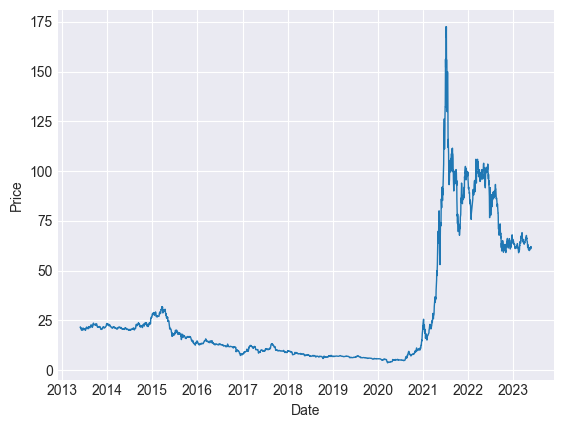

In [23]:
#visualization

import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["GT"],linewidth=1)
plt.show()

In [24]:
#standardize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df.values)
scaled_prices

array([[0.10619929],
       [0.10520675],
       [0.10570303],
       ...,
       [0.34343815],
       [0.34462381],
       [0.33988118]])

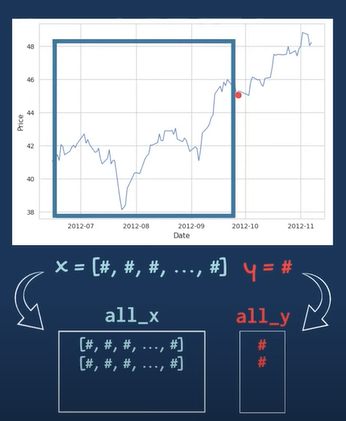

In [25]:
#construct datasets
import numpy as np

moving_size = 60
all_x, all_y = [],[]
for i in range(len(scaled_prices)-moving_size):
  x = scaled_prices[i:i+moving_size]  
  y = scaled_prices[i+moving_size]
  all_x.append(x)
  all_y.append(y)

all_x, all_y = np.array(all_x), np.array(all_y)

In [26]:
print(all_x.shape)
print(all_y.shape)

(2374, 60, 1)
(2374, 1)


In [27]:
#split data
DS_SPLIT = 0.8
train_ds_size = round(all_x.shape[0]*DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [28]:
len(test_x)

475

In [29]:
#split dataset
'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 all_x, all_y, test_size=0.2, random_state=42)
 '''

'\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(\n all_x, all_y, test_size=0.2, random_state=42)\n '

In [30]:
#X_train.shape

In [31]:
#construct model
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [33]:
#train model
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor="val_loss",patience=10, restore_best_weights = True)

model.fit(train_x,train_y,
      validation_split=0.2,
      callbacks=[callback],
      epochs=10)

Epoch 1/10
48/48 [==============================] - 28s 301ms/step - loss: 3.6094e-04 - val_loss: 0.0011
Epoch 2/10
48/48 [==============================] - 11s 223ms/step - loss: 2.0724e-05 - val_loss: 8.4247e-04
Epoch 3/10
48/48 [==============================] - 10s 205ms/step - loss: 1.9975e-05 - val_loss: 7.9275e-04
Epoch 4/10
48/48 [==============================] - 10s 203ms/step - loss: 1.8280e-05 - val_loss: 8.3089e-04
Epoch 5/10
48/48 [==============================] - 11s 240ms/step - loss: 1.7828e-05 - val_loss: 6.6384e-04
Epoch 6/10
48/48 [==============================] - 11s 236ms/step - loss: 1.5977e-05 - val_loss: 6.1523e-04
Epoch 7/10
48/48 [==============================] - 9s 197ms/step - loss: 1.6919e-05 - val_loss: 6.5665e-04
Epoch 8/10
48/48 [==============================] - 12s 240ms/step - loss: 1.5794e-05 - val_loss: 5.0846e-04
Epoch 9/10
48/48 [==============================] - 14s 298ms/step - loss: 1.6966e-05 - val_loss: 5.2677e-04
Epoch 10/10
48/48 [=====

In [34]:
#evalute_model
y_pred = model.predict(test_x)

15/15 [==============================] - 4s 78ms/step


In [35]:
#還原股價
preds = scaler.inverse_transform(y_pred)

In [36]:
test_df

NameError: name 'test_df' is not defined

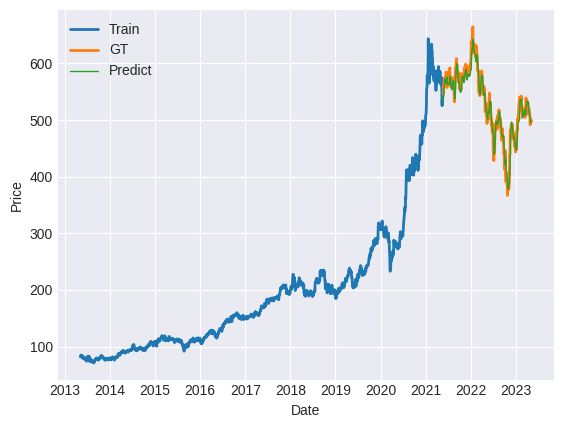

In [ ]:
#visualize result
train_df = df[:train_ds_size+moving_size]
test_df = df[train_ds_size+moving_size:]
test_df = test_df.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(train_df["GT"],linewidth=2)
plt.plot(test_df["GT"],linewidth=2)
plt.plot(test_df["Predict"],linewidth=1)
plt.legend(["Train","GT","Predict"])
plt.show()
